논문 링크 : https://arxiv.org/pdf/1409.4842.pdf

코드참조 : https://mldlcvmjw.tistory.com/292

In [25]:
import tensorflow as tf
import numpy as np
from keras.layers import Input
from tensorflow.keras.layers import Add, Concatenate, Lambda, Dense, Dropout
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D, MaxPooling2D, AveragePooling2D, Flatten
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

In [26]:
from IPython.display import Image

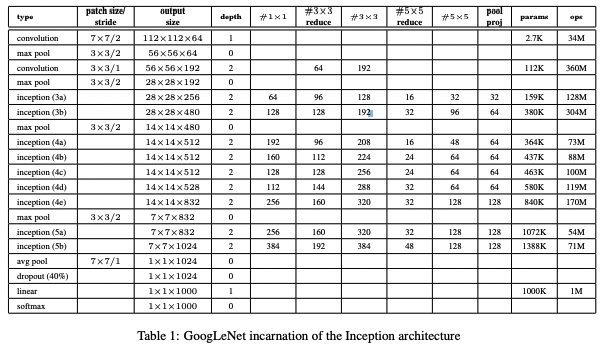

In [27]:
Image('./googlenet_3.png')

In [28]:
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPool2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])

In [29]:
def auxiliary(x,name=None):
    layer=AveragePooling2D((5,5),strides=3,padding='valid')(x)
    layer=Conv2D(128, (1,1), 1,padding='same',activation='relu')(layer)
    layer=Flatten()(layer)
    layer=Dense(1000, activation='relu')(layer)
    layer=Dropout(0.4)(layer)
    layer=Dense(1000, activation='softmax',name=name)(layer)
    return layer

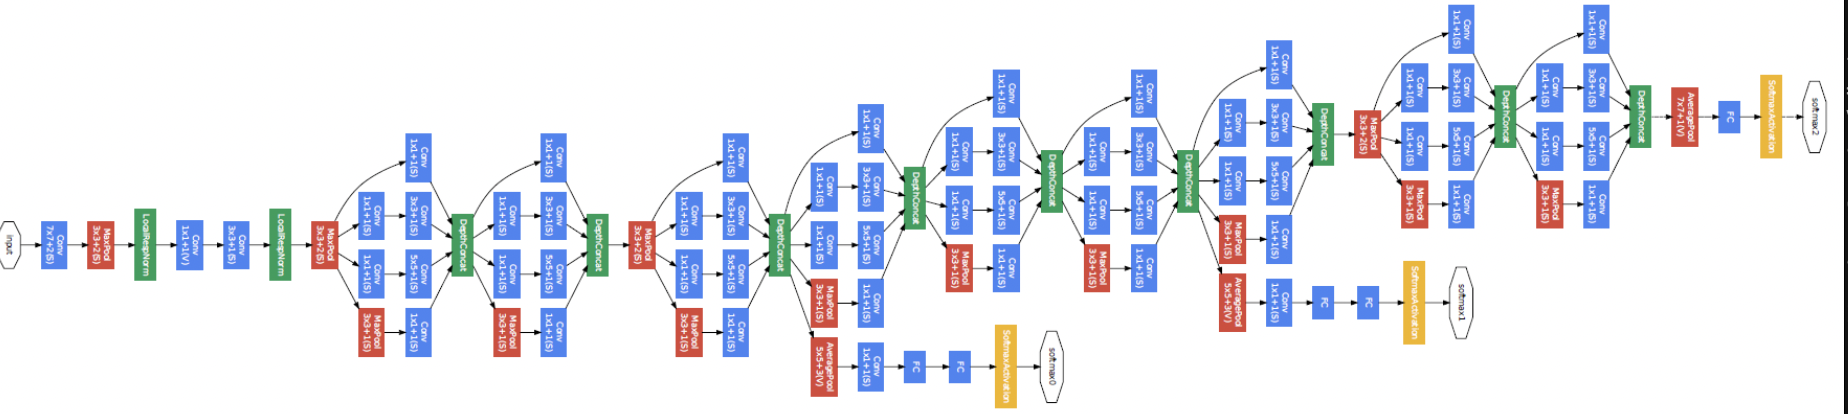

In [30]:
Image('./googlenet_1.png')

In [31]:
def Googlenet_stage1(layer):
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    return layer

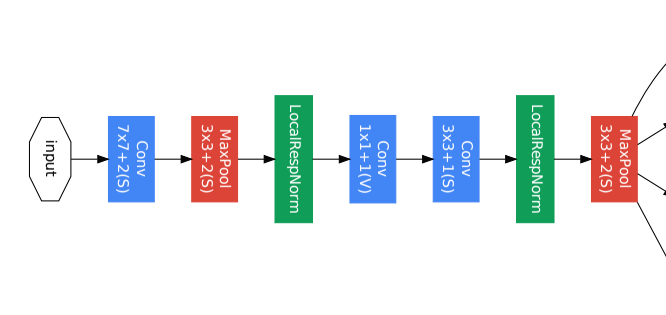

In [32]:
Image('./googlenet_2.png')

In [33]:
def Googlenet_stage2(layer):
    # stage-2
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    return layer

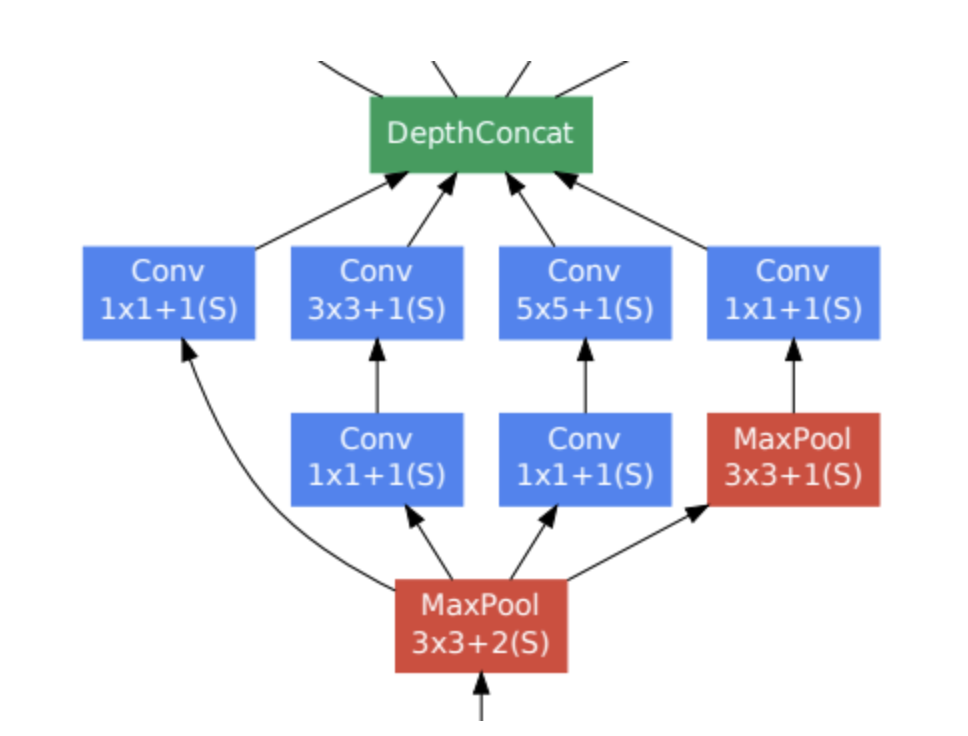

In [34]:
Image('./googlenet_4.png')

In [35]:
def Googlenet_stage3(layer):
    # stage-3
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    return layer, aux1, aux2

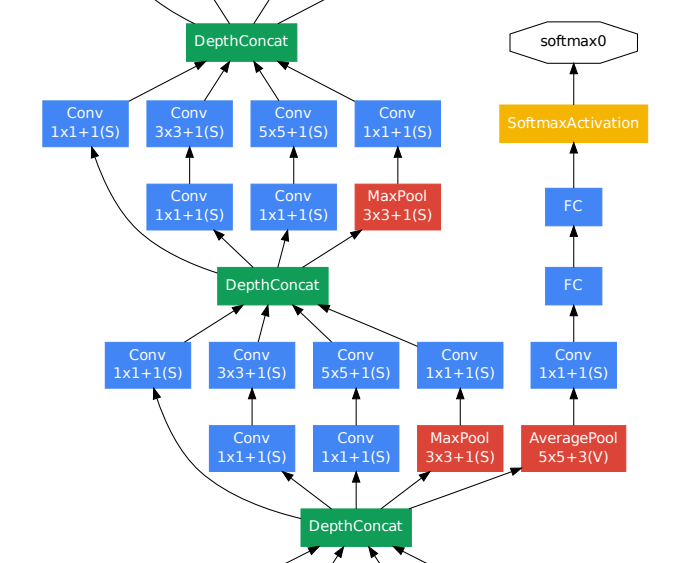

In [36]:
Image('./googlenet_5.png')

In [37]:
def Googlenet_stage4(layer):
    # stage-4
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=1000, activation='linear')(layer)
    main_output = Dense(units=1000, activation='softmax', name='main')(layer)
    
    return main_output

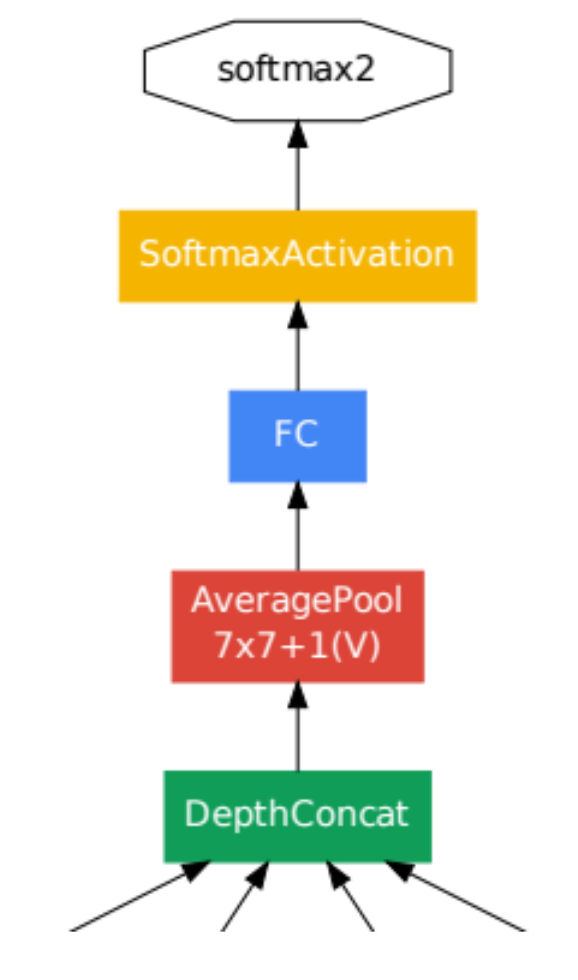

In [38]:
Image('./googlenet_6.png')

In [39]:
def GoogleNet():
    layer_input = Input(shape=(224,224,3))
    
    layer = Googlenet_stage1(layer_input)
    layer = Googlenet_stage2(layer)
    layer, aux1, aux2 = Googlenet_stage3(layer)
    main_output = Googlenet_stage4(layer)

    model = Model(inputs=layer_input, outputs=[main_output, aux1, aux2])
    
    return model

In [40]:
GoogleNet = GoogleNet()
GoogleNet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_119 (Conv2D)            (None, 112, 112, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_26 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv2d_119[0][0]']             
 )                                                                                          

 concatenate_20 (Concatenate)   (None, 14, 14, 512)  0           ['conv2d_134[0][0]',             
                                                                  'conv2d_136[0][0]',             
                                                                  'conv2d_138[0][0]',             
                                                                  'conv2d_139[0][0]']             
                                                                                                  
 conv2d_142 (Conv2D)            (None, 14, 14, 112)  57456       ['concatenate_20[0][0]']         
                                                                                                  
 conv2d_144 (Conv2D)            (None, 14, 14, 24)   12312       ['concatenate_20[0][0]']         
                                                                                                  
 max_pooling2d_32 (MaxPooling2D  (None, 14, 14, 512)  0          ['concatenate_20[0][0]']         
 )        

                                                                  'conv2d_165[0][0]']             
                                                                                                  
 max_pooling2d_36 (MaxPooling2D  (None, 7, 7, 832)   0           ['concatenate_24[0][0]']         
 )                                                                                                
                                                                                                  
 conv2d_167 (Conv2D)            (None, 7, 7, 160)    133280      ['max_pooling2d_36[0][0]']       
                                                                                                  
 conv2d_169 (Conv2D)            (None, 7, 7, 32)     26656       ['max_pooling2d_36[0][0]']       
                                                                                                  
 max_pooling2d_37 (MaxPooling2D  (None, 7, 7, 832)   0           ['max_pooling2d_36[0][0]']       
 )        

Total params: 14,233,952
Trainable params: 14,233,440
Non-trainable params: 512
__________________________________________________________________________________________________
